# Exploration of my friend's movie ratings

Some of my friends and I decided to rate the movies we've seen for fun. I've immediatly realized that more than just looking at those could be done and I decided to dig more into it to try to find trends in our rating, identify similarities between the movies we liked and build a movie recommendation tool from those observation. 

In this notebook, I explore one of my friends' ratings to familiarize myself with the dataset and see what features could be extracted for future analysis. 

One of the first findings is that the movies seen and rated by my friend are good movies as defined by having a high IMDB score. A finding that encourages me to use his judgement to influence my future movie selection. 

In [223]:
import os
import sys
from scipy import stats
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import load_raw, pd, sns, plt
from src.preprocess.clean_reviews import load_reviews
sns.set_palette("viridis")

## Exploring the movies that make up the dataset

In [224]:
df = load_reviews()
df.head(3)

16:36:02 - src.utils - INFO - Loading reviews.csv


,rank,title,team average,imdbrating,joe,cudennec,pierre-yves,mimline,simon,oliver,...,runtime,genre,actors,plot,country,awards,metascore,imdbid,comment,tags
1,1.0,the Godfather,9.5,9.2,9.5,9.6,9.5,NaN,NaN,NaN,...,175.0,"Crime,Drama","Al Pacino,James Caan,Marlon Brando,Richard S. ...",The aging patriarch of an organized crime dyna...,USA,Won 3 Oscars. Another 23 wins & 27 nominations.,100.0,tt0068646,NaN,NaN
2,212.0,The Godfather: Part II,0.0,9.0,9.6,9.4,9.5,NaN,NaN,NaN,...,202.0,"Crime,Drama","Al Pacino,Diane Keaton,Robert De Niro,Robert D...",The early life and career of Vito Corleone in ...,USA,Won 6 Oscars. Another 10 wins & 20 nominations.,85.0,tt0071562,NaN,NaN
3,212.0,A Clockwork Orange,0.0,8.3,9.3,8.9,9.7,NaN,NaN,NaN,...,136.0,"Crime,Drama,Sci-Fi","Malcolm McDowell,Michael Bates,Patrick Magee,W...","In future Britain, Alex DeLarge, a charismatic...","UK,USA",Nominated for 4 Oscars. Another 9 wins & 17 no...,78.0,tt0066921,NaN,NaN


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 1 to 3929
Data columns (total 25 columns):
rank            3819 non-null float64
title           3819 non-null object
team average    3897 non-null float64
imdbrating      3796 non-null float64
joe             145 non-null float64
cudennec        312 non-null float64
pierre-yves     97 non-null float64
mimline         54 non-null float64
simon           0 non-null float64
oliver          1 non-null float64
nina            0 non-null float64
tim             0 non-null float64
# of seen       3819 non-null float64
year            3819 non-null float64
director        3811 non-null object
runtime         862 non-null float64
genre           3813 non-null object
actors          3792 non-null object
plot            3787 non-null object
country         3801 non-null object
awards          3277 non-null object
metascore       2986 non-null float64
imdbid          863 non-null object
comment         0 non-null float64
tags        

In [226]:
df['country'] = df['country'].str.split(',')
print("Movie counts: ",len(df['title'].unique()))

Movie counts:  3813


We can start by looking when those movies were produced and where were the production teams form using the "year" and "country" features. 

In [227]:
df_where = df.explode('country')
df_where['country'] = df_where['country'].str.strip()
df_where = df_where.groupby('country', as_index=False)['title'].count()
df_where= df_where.sort_values('title', ascending=False)
df_where

,country,title
83,USA,3278
82,UK,597
26,Germany,315
24,France,310
15,Canada,265
...,...,...
57,Nigeria,1
64,Puerto Rico,1
36,Iraq,1
43,Kazakhstan,1


In [228]:
print("Number of country :", len(df_where['country'].unique()))

Number of country : 88


Text(0.5, 0, 'Producing country')

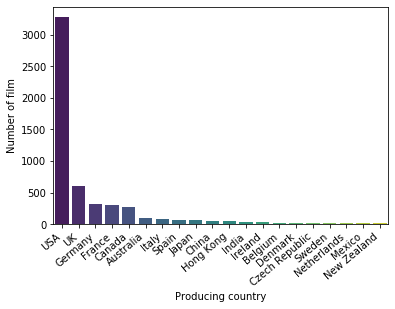

In [229]:
nb_countries = 20
palette = sns.color_palette('viridis', nb_countries)
sns.barplot(x='country', y='title', data = df_where.iloc[:nb_countries], palette=palette)
plt.xticks(rotation=40,horizontalalignment="right")
plt.ylabel('Number of film')
plt.xlabel('Producing country')

Most of the movie were produced by U.S. production teams. The number of movies part produced by american prod teams is higher than the number of movies because more titles are missing. 
The U.K., Germany, France, and Canada are represented in similar proportion in this dataset. 
These figures are not surprising because Amazon has own ImDB since 1998. 

Text(0.5, 0, 'Release year')

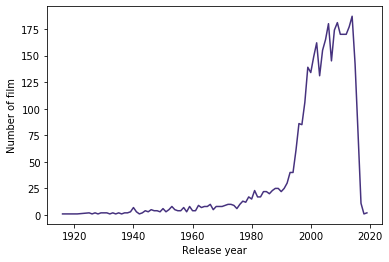

In [235]:
df_when = df.groupby('year', as_index=False)['title'].count()
sns.lineplot(x='year', y='title', data=df_when)
plt.ylabel('Number of film')
plt.xlabel('Release year')

As expected, the number of film is sharply increasing between the 1990 and now. It would be interesting to see if those number compare to the total movie produced over time of if it biased toward the la

## Exploring Cudennec ratings

Across all these reviews, we can see that Thibault has rated the most number of movies with 312 ratings. Joe, PY and Mimline have also rated some movies but probably not enough to extract some good insight. 
We can thus start by exploring the movies rated by Cudennec to try to understand what influences its vote and what features we might want to extract for further analysis. 

First we can take a look at the distribution of his ratings. 

Text(0.5, 1.0, "DIstribution of Thibault's movie ratings")

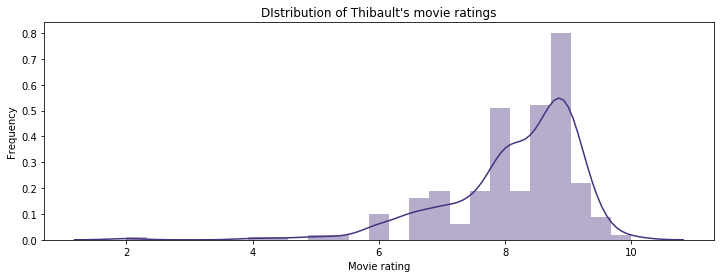

In [201]:
plt.figure(figsize=(12,4))
sns.distplot(df['cudennec'].dropna())
plt.xlabel("Movie rating")
plt.ylabel("Frequency")
plt.title("DIstribution of Thibault's movie ratings")

We can see that his score distribution is highly left-skewed, which means that on average his scores are quite high. 

In [202]:
df['cudennec'].dropna().describe()

count    312.00000
mean       8.15641
std        1.03853
min        2.00000
25%        7.80000
50%        8.45000
75%        8.90000
max       10.00000
Name: cudennec, dtype: float64

That observation is confirmed by the summary stats of his scores where we can notice that his  a first quartile is at 7.8. 

Two hypothesis can explain those high scores: either Thibault has seen mainly good movies or he is very optimistic about the one he's seen. 

## Optimistic or cinephile? 

To test if Thibault has only seen movies worth watching, we can overlay the distribution of scores from IMDB and Metascore to see if the movie were indeed appreciated by the general public. 


In [203]:
df_cud = df[['cudennec', 'imdbrating','metascore']][~df['cudennec'].isnull()]
df_cud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 1 to 886
Data columns (total 3 columns):
cudennec      312 non-null float64
imdbrating    289 non-null float64
metascore     223 non-null float64
dtypes: float64(3)
memory usage: 9.8 KB


In [204]:
df_cud = df_cud.dropna()
df_cud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 1 to 863
Data columns (total 3 columns):
cudennec      223 non-null float64
imdbrating    223 non-null float64
metascore     223 non-null float64
dtypes: float64(3)
memory usage: 7.0 KB


We can see that some of the movies rated by Thibault do not have IMDB ratings, we'll only use 
the subset of 223 movies for which we have all ratings in the distribution plot. We'll also scale down the metascore rating to the [0-10] scale of IMDB. 


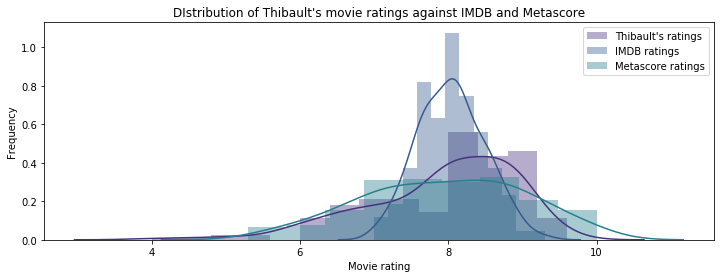

In [205]:
plt.figure(figsize=(12,4))
sns.distplot(df_cud['cudennec'], label="Thibault's ratings")
sns.distplot(df_cud['imdbrating'], label= "IMDB ratings")
df_cud['metascore']= df_cud['metascore']/10
sns.distplot(df_cud['metascore'],label= "Metascore ratings")
plt.xlabel("Movie rating")
plt.ylabel("Frequency")
plt.title("DIstribution of Thibault's movie ratings against IMDB and Metascore")
plt.legend()

In [206]:
df_cud.describe()

,cudennec,imdbrating,metascore
count,223.000000,223.000000,223.000000
mean,7.917040,8.040807,7.929148
std,1.007707,0.444884,1.083788
min,4.000000,7.000000,5.300000
25%,7.400000,7.700000,7.200000
50%,8.000000,8.000000,8.000000
75%,8.700000,8.300000,8.800000
max,9.600000,9.300000,10.000000


In [207]:
print(stats.ttest_ind(df_cud['cudennec'].dropna(),df_cud['imdbrating'].dropna()))
print(stats.ttest_ind(df_cud['cudennec'].dropna(),df_cud['metascore'].dropna()))

Ttest_indResult(statistic=-1.677858682652605, pvalue=0.09407840182209289)
Ttest_indResult(statistic=-0.12217496554784311, pvalue=0.9028157300609854)


It's interesting to see that the scores from Thibault, IMDB and Metascore have a very similar distribution, showing that those movies are on average highly rated with a median of 8.0, from all sources. The t-test also allows use to confirm that the ratings average is not significantly different between each source. This confirms that the movies rated by Thibault were also enjoyed by the general viewer and could be qualified as goo movies if we believe IMDB is a trusted source to determine the quality of a film. 

Now another hypothesis comes up: aren't all viewers just very positive about the movies they watch and skew the average rating of all movie to higher scores. To verify that, we need to see how all movie ratings are distributed in the complete list of IMDB rated movie we have here.

Text(0.5, 1.0, 'Distribution of IMDB movie ratings')

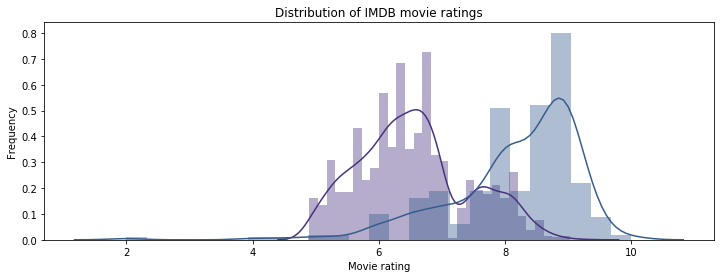

In [208]:
plt.figure(figsize=(12,4))
sns.distplot(df['imdbrating'].dropna())
sns.distplot(df['cudennec'].dropna())
plt.xlabel("Movie rating")
plt.ylabel("Frequency")
plt.title("Distribution of IMDB movie ratings")

In [209]:
df['imdbrating'].dropna().describe()

count    3796.000000
mean        6.545917
std         0.877886
min         4.900000
25%         5.900000
50%         6.500000
75%         7.000000
max         9.300000
Name: imdbrating, dtype: float64

In [210]:
stats.ttest_ind(df['cudennec'].dropna(),df['imdbrating'].dropna())

Ttest_indResult(statistic=30.688329489977807, pvalue=2.2099999552853006e-186)

We get a very different distribution here, confirmed by the t-test that shows that the ratings from IMDB are on average much lower than the ones from the movies rated by Thibault. We see that the median score is 6.5, which let us say that IMDB ratings are slightly more positive that what would be a standard rating scale which could be a modeled as a normal distribution with a mean of 5. 


We this observations can conclude that the movies seen and rated by Thibault are a good selection, with high scores shared by the public opinion. 

If IMDB can be seen as a source of truth due to its high number of rating, another source of truth for identifying appreciated and good movie would be the number of awards and nominations received. We will parse the "award" column to include thoses features in our analysis. 